In [ ]:
# üìå Step 1: Install Required Libraries
#!pip install -q transformers farasapy scikit-learn pandas tqdm

In [43]:
# üìå Step 2: Imports
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
import torch
from farasa.segmenter import FarasaSegmenter
import matplotlib.pyplot as plt

In [45]:
# üìå Step 3: Load Dataset
df = pd.read_csv('full_data_fusionne.csv')
df = df.dropna(subset=['title'])  # Remove rows with missing titles
titles = df['title'].astype(str).tolist()

In [46]:
# üìå Step 4: Arabic Preprocessing
segmenter = FarasaSegmenter(interactive=True)

def preprocess_arabic(text):
    return segmenter.segment(text)

titles_preprocessed = [preprocess_arabic(t) for t in tqdm(titles)]

[2025-04-06 21:01:04,960 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41554/41554 [00:27<00:00, 1512.54it/s]


In [47]:
# üìå Step 5: Load BERT Model & Tokenizer
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(64000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [48]:
# üìå Step 6: Generate Embeddings
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

embeddings = np.array([get_cls_embedding(t) for t in tqdm(titles_preprocessed)])

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41554/41554 [1:20:45<00:00,  8.58it/s]


In [49]:
# üìå Step 7: KMeans Clustering
n_clusters = 5  # You can tune this
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

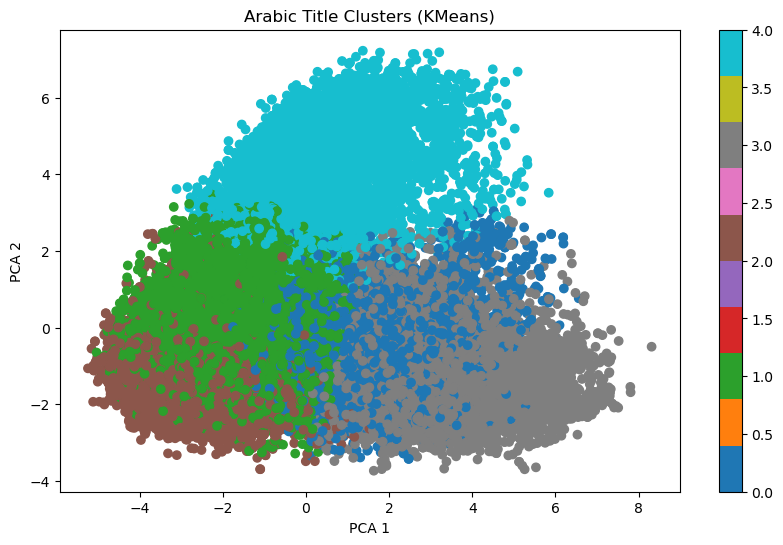

In [50]:
# üìå Step 8: (Optional) Visualization with PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='tab10')
plt.title("Arabic Title Clusters (KMeans)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter)
plt.show()

In [51]:
# üìå Step 9: View Example Titles in Each Cluster
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['title'].head(5).to_string(index=False))


Cluster 0:
ŸàÿµŸàŸÑ ŸÜÿπÿ¥ ÿ•ÿ≥ŸÖÿßÿπŸäŸÑ ŸáŸÜŸäÿ© ÿ•ŸÑŸâ ÿßŸÑÿØŸàÿ≠ÿ© ÿ®ÿπÿØ ÿ¨ŸÜÿßÿ≤ÿ© ÿ≠ÿßÿ¥ÿØ...
ÿ≠ÿ≤ÿ® ÿßŸÑŸÑŸá Ÿäÿ§ŸÉÿØ ŸÖŸÇÿ™ŸÑ ŸÅÿ§ÿßÿØ ÿ¥ŸÉÿ± ÿ®ÿ∂ÿ±ÿ®ÿ© ÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑŸäÿ© ŸàÿÆÿ∑...
                ÿ™ŸàŸÜÿ≥.. ÿ¥ÿ®ÿßÿ® Ÿäÿ®ÿ™ŸÉÿ±ŸàŸÜ ÿ±Ÿàÿ®Ÿàÿ™ÿß ÿ™ŸÅÿßÿπŸÑŸäÿß
ÿ£ÿ±ÿ®ÿπÿ© ŸÖÿ≠ÿßŸàÿ± ŸÑŸÖÿπÿ±ŸÅÿ© ÿ™ŸÅÿßÿµŸäŸÑ ÿßŸÑŸáÿ¨ŸàŸÖ ÿßŸÑÿ®ÿ±Ÿä ÿßŸÑÿ•ÿ≥ÿ±ÿßÿ¶Ÿä...
ŸÖŸÅÿ±ŸÇÿπÿßÿ™ Ÿàÿ™Ÿàÿ≤Ÿäÿπ ÿ≠ŸÑŸàŸâ ŸÅŸä ÿ•ÿØŸÑÿ® ÿßŸÑÿ≥Ÿàÿ±Ÿäÿ© ÿßÿ®ÿ™Ÿáÿßÿ¨ÿß ÿ®ŸÖŸÇ...

Cluster 1:
ÿ™ŸÜÿØŸäÿØÿß ÿ®ÿßÿ∫ÿ™ŸäÿßŸÑ ŸáŸÜŸäÿ©... ŸÖÿ∏ÿßŸáÿ±ÿßÿ™ ŸÖŸÜÿßŸáÿ∂ÿ© ŸÑÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑ ...
ÿÆŸÑŸäŸÑ ÿßŸÑÿ≠Ÿäÿ© ÿπŸÜ ÿßÿ∫ÿ™ŸäÿßŸÑ ŸáŸÜŸäÿ©.. Ÿáÿ∞Ÿá ÿ¨ÿ±ŸäŸÖÿ© ŸÑÿß ÿ®ÿØ ŸÑŸÖÿ±...
ÿßÿ∫ÿ™ŸäÿßŸÑ ÿ•ÿ≥ŸÖÿßÿπŸäŸÑ ŸáŸÜŸäÿ©.. Ÿàÿßÿ¥ŸÜÿ∑ŸÜ ÿ™ŸÜŸÅŸä ÿ™Ÿàÿ±ÿ∑Ÿáÿß ŸàŸÇŸÑŸÇ ÿØ...
ÿßŸÑÿ¨Ÿäÿ¥ ÿßŸÑÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑŸä Ÿäÿ§ŸÉÿØ "ŸÖŸÇÿ™ŸÑ" ŸÇÿßÿ¶ÿØ ÿßŸÑÿ¨ŸÜÿßÿ≠ ÿßŸÑÿπÿ≥ŸÉÿ±...
ÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑ ÿ™ÿ§ŸÉÿØ "ŸÖŸÇÿ™ŸÑ" ŸÖÿ≠ŸÖÿØ ÿßŸÑÿ∂ŸäŸÅ ÿ®ÿ∂ÿ±ÿ®ÿ© ÿ¨ŸàŸäÿ© ÿπŸÑŸâ ÿ∫...

Cluster 2:
ÿßŸÑÿ£ŸÑÿπÿßÿ® ÿßŸÑÿ£ŸàŸÑŸÖÿ®Ÿäÿ©: ÿßŸÑŸÖŸÑÿßŸÉŸÖÿ© ÿÆŸÑŸäŸÅ ÿ™ÿ®ŸÑÿ∫ ÿ±ÿ®ÿπ ÿß

In [52]:
from sklearn.metrics import silhouette_score

score = silhouette_score(embeddings, df['cluster'])
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.0564


In [53]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, preds)
    print(f"k={k} --> Silhouette Score: {score:.4f}")


k=2 --> Silhouette Score: 0.0813
k=3 --> Silhouette Score: 0.0817
k=4 --> Silhouette Score: 0.0680
k=5 --> Silhouette Score: 0.0564
k=6 --> Silhouette Score: 0.0510
k=7 --> Silhouette Score: 0.0548
k=8 --> Silhouette Score: 0.0599
k=9 --> Silhouette Score: 0.0580
k=10 --> Silhouette Score: 0.0491


In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings_pca)

sil_score = silhouette_score(embeddings_pca, df['cluster'])
print(f"Silhouette Score after PCA: {sil_score:.4f}")


Silhouette Score after PCA: 0.0829


In [73]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
df['cluster_hdbscan'] = clusterer.fit_predict(embeddings_pca)

# Check number of clusters found
print(f"HDBSCAN found {df['cluster_hdbscan'].nunique()} clusters")

# Silhouette Score (only for non-outliers)
mask = df['cluster_hdbscan'] != -1
print("Silhouette Score (HDBSCAN):", silhouette_score(embeddings_pca[mask], df['cluster_hdbscan'][mask]))


HDBSCAN found 2 clusters
Silhouette Score (HDBSCAN): 0.5673016


In [56]:
for i in sorted(df['cluster_hdbscan'].unique()):
    if i == -1:
        print(f"\nCluster -1 (outliers):")
    else:
        print(f"\nCluster {i}:")
    print(df[df['cluster_hdbscan'] == i]['title'].head(5).to_string(index=False))



Cluster 0:
ÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑ ÿ™ŸàÿßÿµŸÑ ŸÇÿµŸÅ ÿ∫ÿ≤ÿ© ÿ∫ÿØÿßÿ© ŸÖŸÇÿ™ÿ±ÿ≠ ÿ¨ÿØŸäÿØ ŸÑŸàŸÇŸÅ ÿ•ÿ∑ŸÑÿß...
              ŸÅÿ±ŸÜÿ≥ÿß: ŸáŸÑ ÿØŸÇÿ™ ÿ≥ÿßÿπÿ© ÿßŸÑŸÜŸáÿßŸäÿ© ŸÑÿ®ÿßÿ±ŸÜŸäŸäŸáÿü
                        ÿ∫ÿ≤ÿ©: ŸáŸÑ ÿ™ÿ®ÿØÿØÿ™ ÿ¢ŸÖÿßŸÑ ÿßŸÑŸáÿØŸÜÿ©ÿü
    ÿ∫ÿßÿ±ÿßÿ™ ÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑŸäÿ© ŸÖŸÉÿ´ŸÅÿ© ŸàŸÖÿ≥ÿ™ÿ¥ŸÅŸäÿßÿ™ ÿ∫ÿ≤ÿ© ÿ™ÿπÿ¨ ÿ®ÿßŸÑÿ¨ÿ´ÿ´
             ŸÖÿ¥ÿßÿ±ŸÉÿ© ŸÇŸäÿßÿ≥Ÿäÿ© Ÿàÿ≥ÿ∑ ÿ•ÿ¨ÿ±ÿßÿ°ÿßÿ™ ÿ£ŸÖŸÜŸäÿ© ŸÖÿ¥ÿØÿØÿ©

Cluster 1:
ÿßŸÑÿ£ŸÑÿπÿßÿ® ÿßŸÑÿ£ŸàŸÑŸÖÿ®Ÿäÿ©: ÿßŸÑŸÖŸÑÿßŸÉŸÖÿ© ÿÆŸÑŸäŸÅ ÿ™ÿ®ŸÑÿ∫ ÿ±ÿ®ÿπ ÿßŸÑŸÜŸáÿß...
ŸÖÿ≠ÿ∑ÿ© ÿ£ŸÅÿ±ŸäŸÇŸäÿß ŸÅŸä ÿßŸÑÿ£ŸÑÿπÿßÿ® ÿßŸÑÿ£ŸàŸÑŸÖÿ®Ÿäÿ© ÿ®ÿ®ÿßÿ±Ÿäÿ≥: "ÿÆŸäŸÖÿ©...
ÿ™ŸÜÿØŸäÿØÿß ÿ®ÿßÿ∫ÿ™ŸäÿßŸÑ ŸáŸÜŸäÿ©... ŸÖÿ∏ÿßŸáÿ±ÿßÿ™ ŸÖŸÜÿßŸáÿ∂ÿ© ŸÑÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑ ...
ÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑ "ÿ™ÿ∫ÿ™ÿßŸÑ" ÿµÿ≠ŸÅŸäÿß ŸàŸÖÿµŸàÿ±ÿß ŸÖŸÜ ŸÇŸÜÿßÿ© ÿßŸÑÿ¨ÿ≤Ÿäÿ±ÿ© ŸÅŸä...
ÿÆŸÑŸäŸÑ ÿßŸÑÿ≠Ÿäÿ© ÿπŸÜ ÿßÿ∫ÿ™ŸäÿßŸÑ ŸáŸÜŸäÿ©.. Ÿáÿ∞Ÿá ÿ¨ÿ±ŸäŸÖÿ© ŸÑÿß ÿ®ÿØ ŸÑŸÖÿ±...


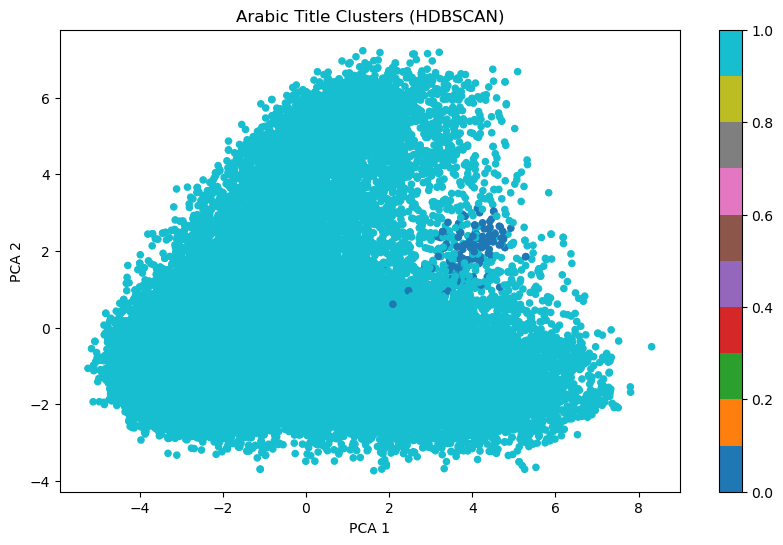

In [57]:
plt.figure(figsize=(10, 6))
colors = df['cluster_hdbscan']
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=colors, cmap='tab10', s=20)
plt.title("Arabic Title Clusters (HDBSCAN)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter)
plt.show()
